# Segmentation d'images

*Le but d'une segmentation d'images est de répérer les formes de différents objets sur une image*

Je vais implémenter From Scratch le réseau U-NET dont l'architecture neuronalle peut être observé ici :

https://arxiv.org/abs/1505.04597

# Récupération d'un jeu de données de bactérie vue au microscope



In [1]:
!wget -O 'IRM_dataset.zip' "https://storage.googleapis.com/kaggle-data-sets/700922%2F1225399%2Fbundle%2Farchive.zip?GoogleAccessId=gcp-kaggle-com@kaggle-161607.iam.gserviceaccount.com&Expires=1599764539&Signature=iWKDOCgiAGsRN0lMTIPtaZqURC9QPf%2BAb5J9%2F5iETs1UMfCjUa3dOeboAoUARo1oeYr8vde9WAWaBRf0sfcnWGH4CFszPqtOwSQtM696bFVCE%2FupApztwfKjHy80wsLqkkXjlRJhiCjtHyIF0EVJ4sqcnEy0nubxhf5q9BGYnSrsTaBuXRMbj%2FxuSny9qH03ELDFiGvb5qta9OXxzuPnlPMqWE17duUmBYaK1Vegvri00mDoK7jAgMa9zg2fxsutap86o5PktL%2F0oapPIxS%2F0jhIozK4J6r4gISdPnS2gVPwmcI1UQbKQi8OfO7P4%2BI54ojlEKt4p4hQ8KFnj6ux0g%3D%3D"

--2020-09-10 18:40:41--  https://storage.googleapis.com/kaggle-data-sets/700922%2F1225399%2Fbundle%2Farchive.zip?GoogleAccessId=gcp-kaggle-com@kaggle-161607.iam.gserviceaccount.com&Expires=1599764539&Signature=iWKDOCgiAGsRN0lMTIPtaZqURC9QPf%2BAb5J9%2F5iETs1UMfCjUa3dOeboAoUARo1oeYr8vde9WAWaBRf0sfcnWGH4CFszPqtOwSQtM696bFVCE%2FupApztwfKjHy80wsLqkkXjlRJhiCjtHyIF0EVJ4sqcnEy0nubxhf5q9BGYnSrsTaBuXRMbj%2FxuSny9qH03ELDFiGvb5qta9OXxzuPnlPMqWE17duUmBYaK1Vegvri00mDoK7jAgMa9zg2fxsutap86o5PktL%2F0oapPIxS%2F0jhIozK4J6r4gISdPnS2gVPwmcI1UQbKQi8OfO7P4%2BI54ojlEKt4p4hQ8KFnj6ux0g%3D%3D
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169991422 (162M) [application/zip]
Saving to: ‘IRM_dataset.zip’

IRM_dataset.zip     100%[===================>] 162.12M  83.3MB/s    in 1.9s    

2020-09-10 18:40:4

In [2]:
!unzip "/content/IRM_dataset.zip" -d '/content/irm_dataset'

Archive:  /content/IRM_dataset.zip
  inflating: /content/irm_dataset/images/001.png  
  inflating: /content/irm_dataset/images/002.png  
  inflating: /content/irm_dataset/images/003.png  
  inflating: /content/irm_dataset/images/004.png  
  inflating: /content/irm_dataset/images/005.png  
  inflating: /content/irm_dataset/images/006.png  
  inflating: /content/irm_dataset/images/007.png  
  inflating: /content/irm_dataset/images/008.png  
  inflating: /content/irm_dataset/images/009.png  
  inflating: /content/irm_dataset/images/010.png  
  inflating: /content/irm_dataset/images/011.png  
  inflating: /content/irm_dataset/images/012.png  
  inflating: /content/irm_dataset/images/013.png  
  inflating: /content/irm_dataset/images/014.png  
  inflating: /content/irm_dataset/images/015.png  
  inflating: /content/irm_dataset/images/016.png  
  inflating: /content/irm_dataset/images/017.png  
  inflating: /content/irm_dataset/images/018.png  
  inflating: /content/irm_dataset/images/019.pn

# Exploration

Dimension d'une image d'entree: (720, 710, 3)
Dimension d'un masque: (720, 710)


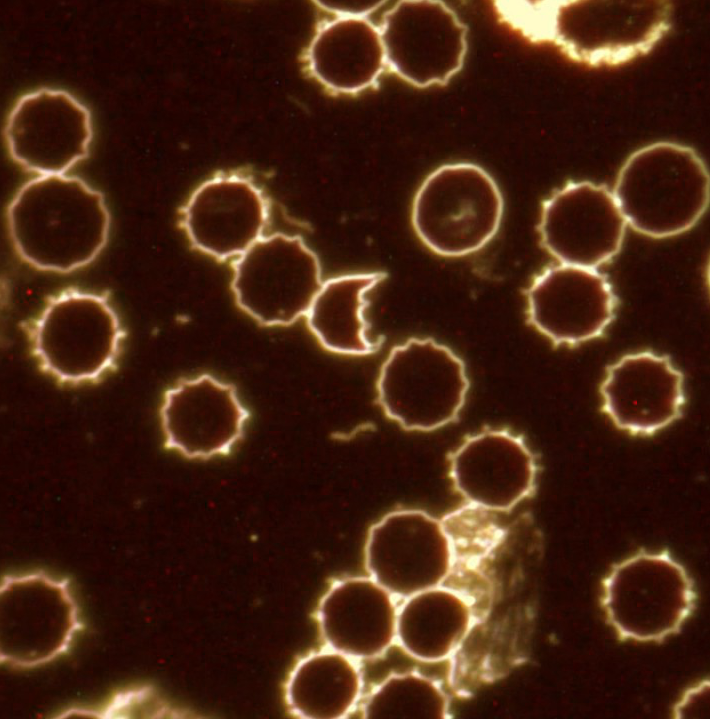

In [3]:
import cv2 as cv 
import numpy as np
from google.colab.patches import cv2_imshow as imshow

img_array = cv.imread("/content/irm_dataset/images/001.png",cv.IMREAD_COLOR) 
img_array = img_array[:, :, [2, 1, 0]] # Transform BGR to RGB
seg_img = cv.imread("/content/irm_dataset/masks/001.png",cv.IMREAD_GRAYSCALE)

print("Dimension d'une image d'entree: "+str(np.shape(img_array)))
print("Dimension d'un masque: "+str(np.shape(seg_img)))
imshow(img_array)

__Feature Engineering__ : on applique le masque à l'image originelle. 

* Mask_value == 1 => Associe la couleur rouge
* Mask_value == 0 ==> Associe la couleur bleue


In [4]:
mask_applied = img_array.copy()
mask_applied[seg_img == 1] = [255, 0, 0]
mask_applied[seg_img == 2] = [255, 255, 0]

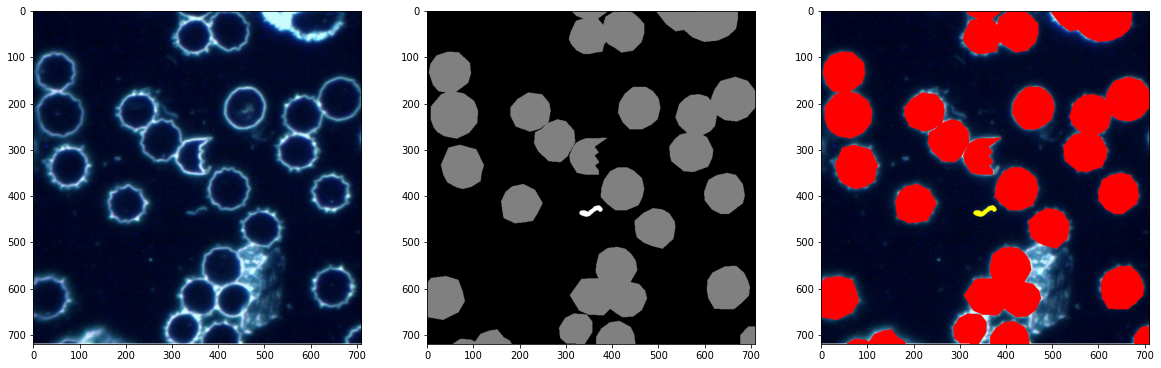

In [5]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(img_array)
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(seg_img, cmap="gray")
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(mask_applied)


# __Data prep__

In [6]:
import tensorflow as tf
import os
import random
import numpy as np
 
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [7]:
seed = 42
np.random.seed = seed

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3


__Constitution du Dataset__

In [8]:
TRAIN_PATH = "/content/train/images/"
TEST_PATH = "/content/label/masks/"

train_ids = next(os.walk(TRAIN_PATH))[2]
test_ids = next(os.walk(TEST_PATH))[2]

In [9]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

__Redimensionner les images car notre UNET prendra en entrée des images de tailles 128,128__


In [10]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(path )[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    path_to_test = TEST_PATH + id_
    mask_ = cv.imread(path_to_test,cv.IMREAD_GRAYSCALE)
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
    mask = np.maximum(mask, mask_)  
            
    Y_train[n] = mask   

  0%|          | 0/366 [00:00<?, ?it/s]

Resizing training images and masks


100%|██████████| 366/366 [00:41<00:00,  8.72it/s]


__Train/test split__

In [11]:
from sklearn.model_selection import train_test_split

x_app, x_test, y_app, y_test = train_test_split(X_train,Y_train, train_size=0.75)

__model__

In [12]:
import tensorflow as tf


inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Chemin droit
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#UpSampling
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
_______________________________________________________________________________________

__Entrainement__

In [13]:
history = model.fit(x_app,y_app, validation_split=(0.1),batch_size=64,epochs=15,verbose=1)

Epoch 1/15
4/4 [==============================] - 2s 511ms/step - loss: 0.6509 - accuracy: 0.6520 - val_loss: 0.3515 - val_accuracy: 0.9434
Epoch 2/15
4/4 [==============================] - 1s 128ms/step - loss: 0.4674 - accuracy: 0.9310 - val_loss: 0.4723 - val_accuracy: 0.9526
Epoch 3/15
4/4 [==============================] - 1s 129ms/step - loss: 0.4560 - accuracy: 0.9408 - val_loss: 0.3513 - val_accuracy: 0.9527
Epoch 4/15
4/4 [==============================] - 1s 128ms/step - loss: 0.3802 - accuracy: 0.9422 - val_loss: 0.4525 - val_accuracy: 0.9527
Epoch 5/15
4/4 [==============================] - 1s 127ms/step - loss: 0.3916 - accuracy: 0.9426 - val_loss: 0.3299 - val_accuracy: 0.9527
Epoch 6/15
4/4 [==============================] - 1s 128ms/step - loss: 0.3455 - accuracy: 0.9426 - val_loss: 0.3396 - val_accuracy: 0.9527
Epoch 7/15
4/4 [==============================] - 1s 129ms/step - loss: 0.3136 - accuracy: 0.9427 - val_loss: 0.3173 - val_accuracy: 0.9527
Epoch 8/15
4/4 [====

In [14]:
model.evaluate(x_test,y_test)

3/3 [==============================] - 0s 11ms/step - loss: 0.1813 - accuracy: 0.9324


[0.18133926391601562, 0.9324327707290649]

__Visualisation de quelques segmentations__

In [15]:
predictions = model.predict(x_test)

In [16]:
np.shape(predictions)

(92, 128, 128, 1)

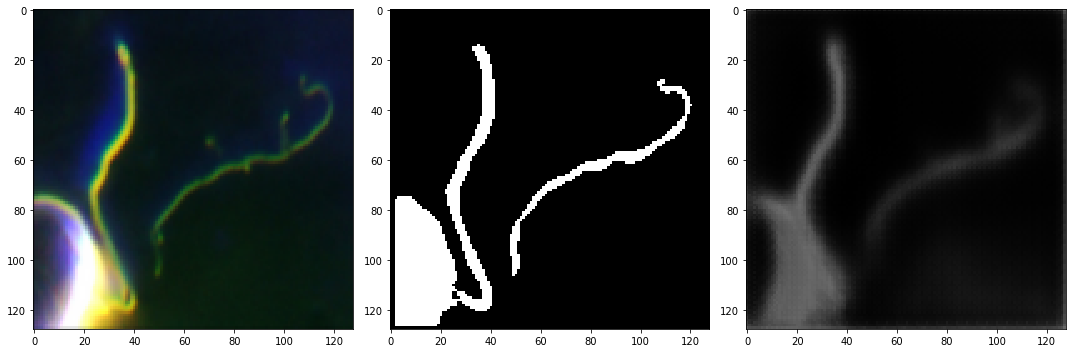

In [17]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(predictions))

fig = plt.figure(figsize=(15,20))
im1 = fig.add_subplot(1,3,1)
imshow(x_test[ix])
im2 = fig.add_subplot(1,3,2)
imshow(np.squeeze(y_test[ix]))
im3 = fig.add_subplot(1,3,3)
imshow(np.squeeze(predictions[ix]))
